In [19]:
#Rohan's part starts here

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import pickle
import catboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 
import joblib

In [23]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-06-2020.csv')


In [24]:
confirmed_df.head()
#latest_data.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,39186,39192,39227,39233,39254,39268,39285,39290,39297,39341
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,13045,13153,13259,13391,13518,13649,13806,13965,14117,14266
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,50754,50914,51067,51213,51368,51530,51690,51847,51995,52136
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1836,1836,1836,1966,1966,2050,2050,2110,2110,2110
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,4590,4672,4718,4797,4905,4972,5114,5211,5370,5402


In [25]:
cols = confirmed_df.keys()

In [26]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]




In [27]:
from __future__ import division
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
total_recovered = [] 
total_active = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    

[548,
 643,
 920,
 1406,
 2075,
 2877,
 5509,
 6087,
 8141,
 9802,
 11891,
 16630,
 19716,
 23707,
 27440,
 30587,
 34110,
 36814,
 39829,
 42354,
 44386,
 44759,
 59895,
 66358,
 68413,
 70513,
 72434,
 74211,
 74619,
 75077,
 75550,
 77001,
 77022,
 77241,
 77754,
 78166,
 78600,
 78928,
 79356,
 79932,
 80136,
 80261,
 80386,
 80537,
 80690,
 80770,
 80823,
 80860,
 80887,
 80921,
 80932,
 80945,
 80977,
 81003,
 81033,
 81058,
 81102,
 81156,
 81250,
 81305,
 81435,
 81498,
 81591,
 81661,
 81782,
 81897,
 81999,
 82122,
 82198,
 82279,
 82361,
 82432,
 82511,
 82543,
 82602,
 82665,
 82718,
 82809,
 82883,
 82941,
 83014,
 83134,
 83213,
 83306,
 83356,
 83403,
 83760,
 83787,
 83805,
 83817,
 83853,
 83868,
 83884,
 83899,
 83909,
 83912,
 83918,
 83940,
 83944,
 83956,
 83959,
 83959,
 83964,
 83966,
 83968,
 83970,
 83975,
 83976,
 83990,
 84010,
 84011,
 84018]

In [28]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)


# deaths
world_daily_death = daily_increase(total_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)


In [29]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [30]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]
print(dates)

Index([u'1/22/20', u'1/23/20', u'1/24/20', u'1/25/20', u'1/26/20', u'1/27/20',
       u'1/28/20', u'1/29/20', u'1/30/20', u'1/31/20',
       ...
       u'9/25/20', u'9/26/20', u'9/27/20', u'9/28/20', u'9/29/20', u'9/30/20',
       u'10/1/20', u'10/2/20', u'10/3/20', u'10/4/20'],
      dtype='object', length=257)


In [31]:
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [33]:
#World cases
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.36, shuffle=False)


In [34]:
# svm_confirmed = svm_search.best_estimator_
from sklearn.svm import SVR
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed.ravel())
svm_pred = svm_confirmed.predict(future_forcast)

('MAE:', 3114202.3436413617)
('MSE:', 16585237006296.484)


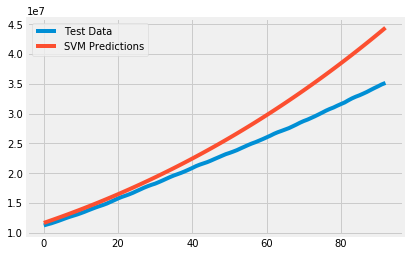

In [35]:
# check against testing data
import matplotlib.pyplot as plt 

svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))


In [36]:
import pickle
from sklearn.externals import joblib
filename = 'covid19.pkl'
joblib.dump(svm_confirmed,filename)

#Load from file
file_load = joblib.load(filename)
file_load

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
#Total deaths
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.36, shuffle=False)



In [38]:
# svm_deaths = svm_search.best_estimator_
from sklearn.svm import SVR
svm_deaths = SVR(shrinking=True, kernel='poly',gamma=0.001, epsilon=1,degree=4, C=0.1)
svm_deaths.fit(X_train_deaths, y_train_deaths.ravel())
svm_pred_deaths = svm_deaths.predict(future_forcast)

('MAE:', 1018035.753697721)
('MSE:', 1543120820698.2573)


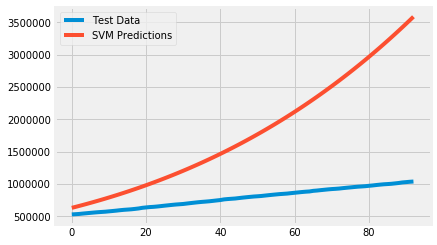

In [39]:
# check against testing data
import matplotlib.pyplot as plt 
svm_test_pred_deaths = svm_deaths.predict(X_test_deaths)
plt.plot(y_test_deaths)
plt.plot(svm_test_pred_deaths)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred_deaths, y_test_deaths))
print('MSE:',mean_squared_error(svm_test_pred_deaths, y_test_deaths))

In [40]:
#Total deaths
import pickle
from sklearn.externals import joblib
filename2 = 'covid19_deaths.pkl'
joblib.dump(svm_deaths,filename2)

#Load from file
file_load2 = joblib.load(filename2)
file_load2

SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=1, gamma=0.001,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [69]:
#Total recovered
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.36, shuffle=False)



In [70]:
# svm_recovered = svm_search.best_estimator_
from sklearn.svm import SVR
svm_recovered = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_recovered.fit(X_train_recovered, y_train_recovered.ravel())

SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

('MAE:', 1732313.047269774)
('MSE:', 4718809843595.613)


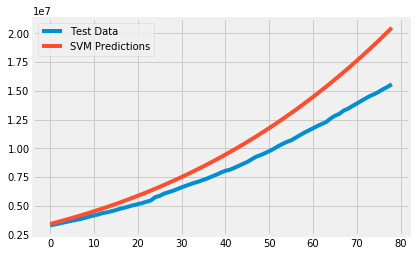

In [71]:
# check against testing data
import matplotlib.pyplot as plt 
svm_test_pred_recovered = svm_recovered.predict(X_test_recovered)
plt.plot(y_test_recovered)
plt.plot(svm_test_pred_recovered)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred_recovered, y_test_recovered))
print('MSE:',mean_squared_error(svm_test_pred_recovered, y_test_recovered))

In [72]:
#Total recovered
import pickle
from sklearn.externals import joblib
filename3 = 'covid19_recovered.pkl'
joblib.dump(svm_recovered,filename3)

#Load from file
file_load3 = joblib.load(filename3)
file_load3

SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [73]:
#Total active
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train_active, X_test_active, y_train_active, y_test_active = train_test_split(days_since_1_22, total_active, test_size=0.36, shuffle=False)

In [74]:
# svm_active = svm_search.best_estimator_
from sklearn.svm import SVR
svm_active = SVR(shrinking=True, kernel='poly',gamma=0.1, epsilon=1,degree=3, C=0.1)
svm_active.fit(X_train_active, y_train_active)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

('MAE:', 4103520.685145248)
('MSE:', 22287279271175.7)


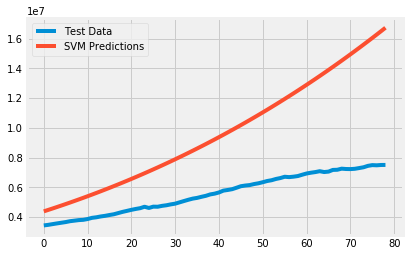

In [75]:
# check against testing data
import matplotlib.pyplot as plt 
svm_test_pred_active = svm_active.predict(X_test_active)
plt.plot(y_test_active)
plt.plot(svm_test_pred_active)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred_active, y_test_active))
print('MSE:',mean_squared_error(svm_test_pred_active, y_test_active))

In [76]:
#Total active cases
import pickle
from sklearn.externals import joblib
filename4 = 'covid19_active.pkl'
joblib.dump(svm_active,filename4)

#Load from file
file_load4 = joblib.load(filename4)
file_load4

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
# transform our data for polynomial regression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)


In [79]:
# polynomial regression
from sklearn.linear_model import LinearRegression, BayesianRidge

linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)

print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

('MAE:', 1971292.952903436)
('MSE:', 6748625230551.764)


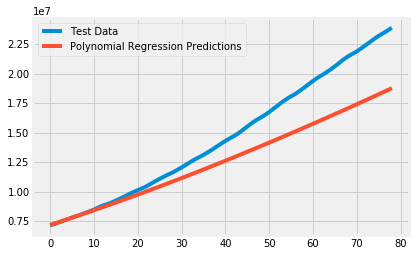

In [80]:
#Shankha's part starts here


#print(linear_model.coef_)
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

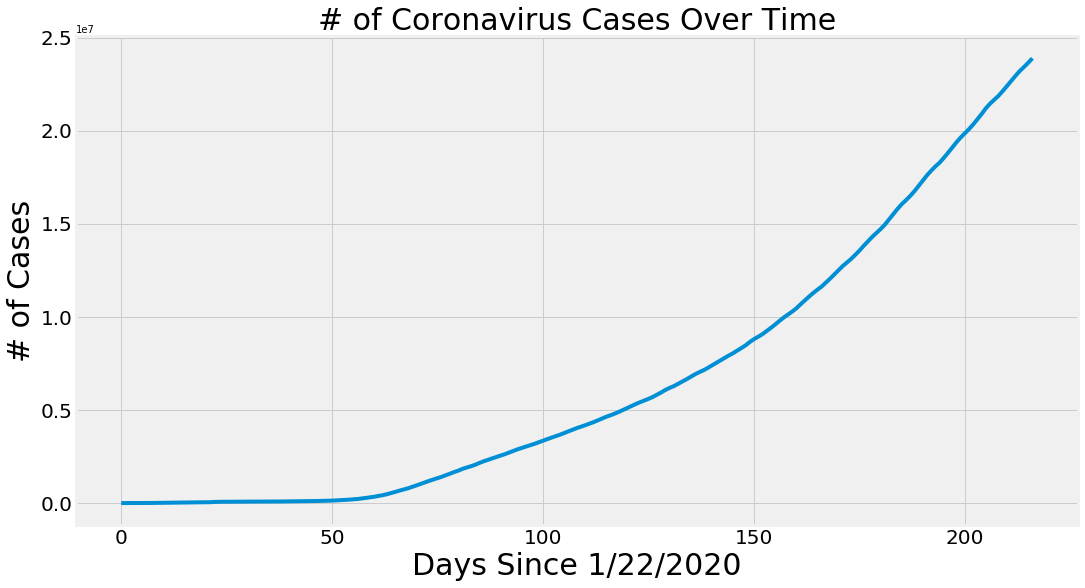

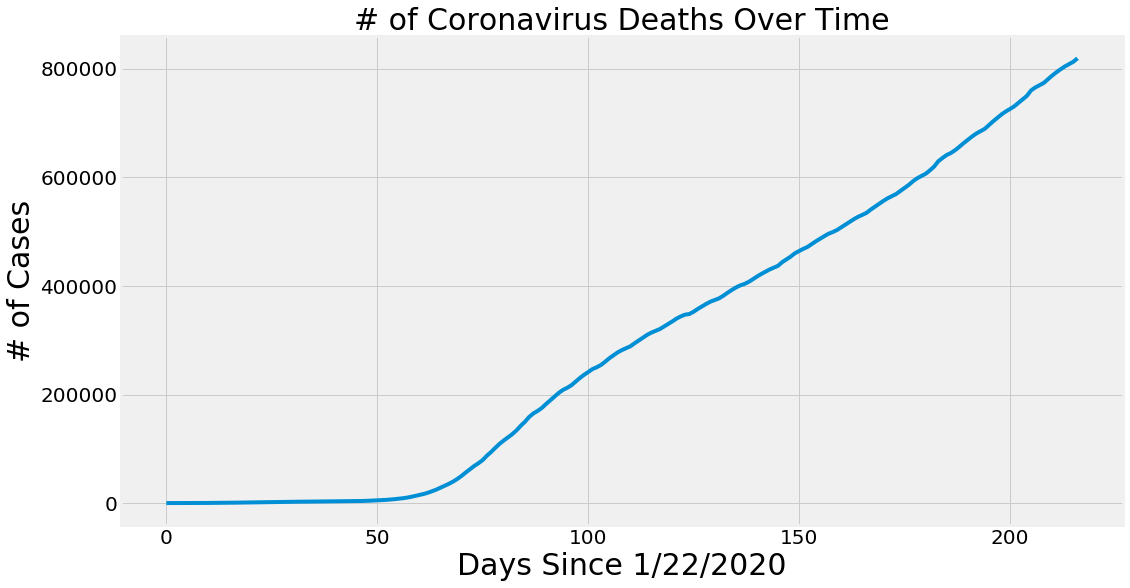

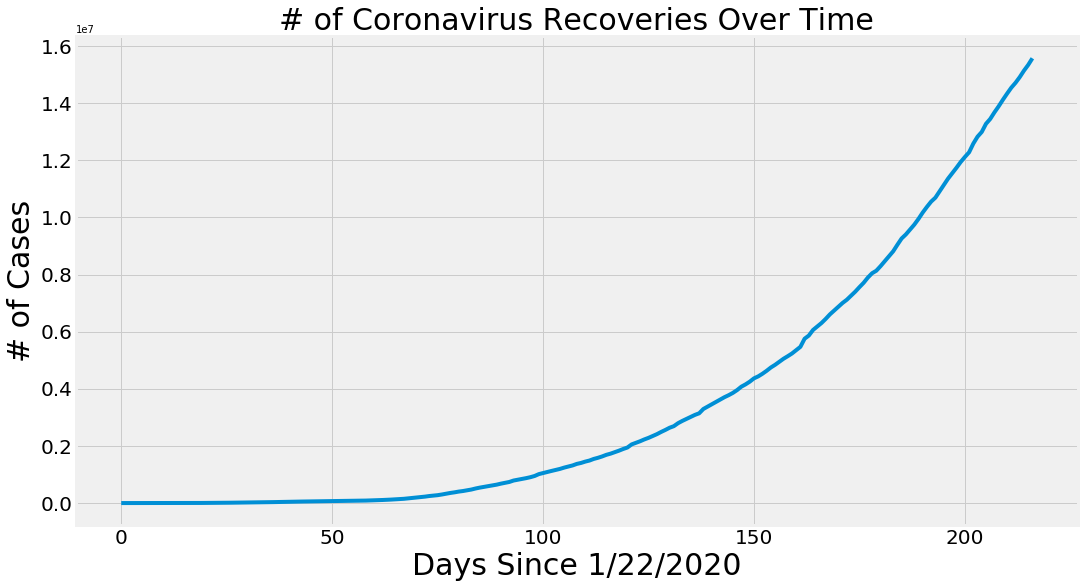

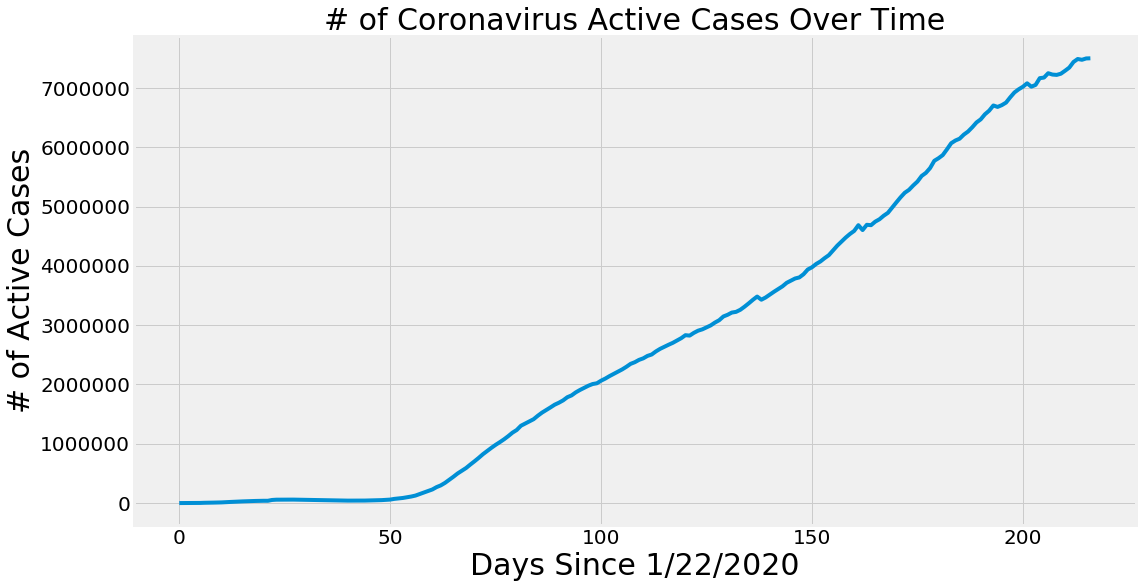

In [81]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

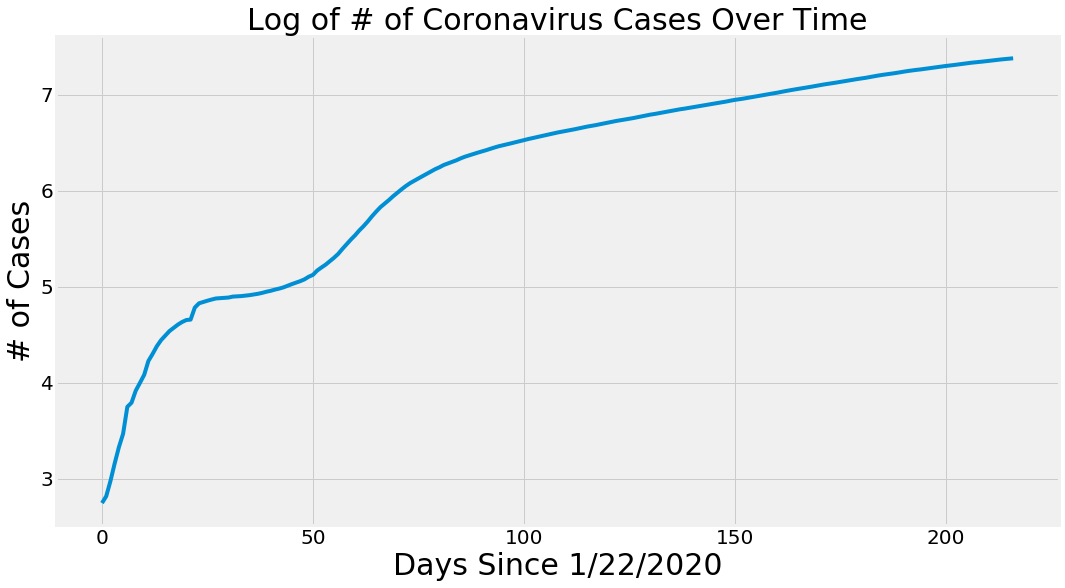

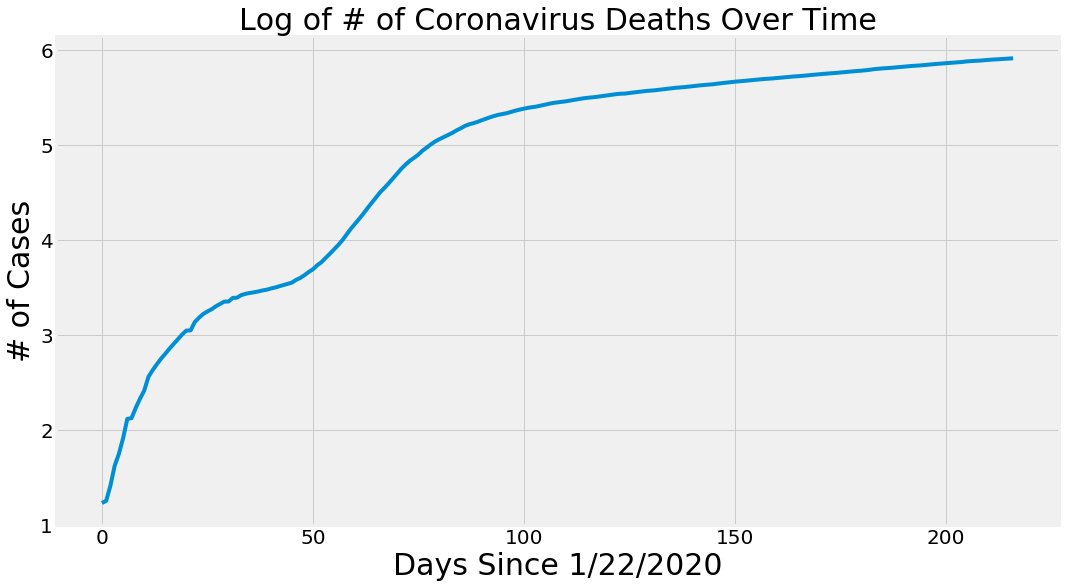

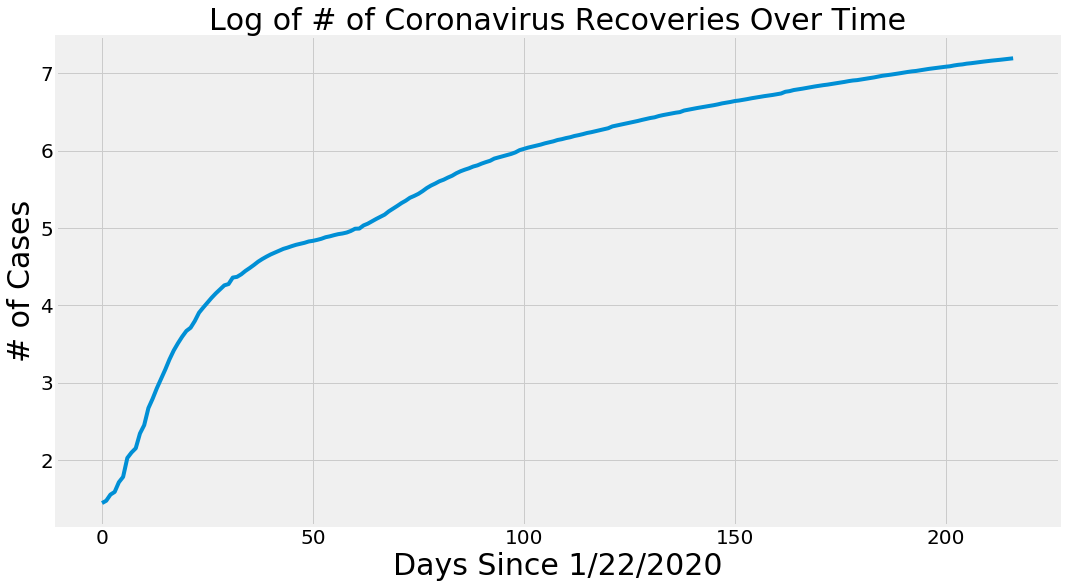

In [35]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(total_recovered))
plt.title('Log of # of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [82]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [54]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, france_cases)
plt.plot(adjusted_dates, germany_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, spain_deaths)
plt.plot(adjusted_dates, france_deaths)
plt.plot(adjusted_dates, germany_deaths)

plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, spain_recoveries)
plt.plot(adjusted_dates, france_recoveries)
plt.plot(adjusted_dates, germany_recoveries)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain', 'France', 'Germany'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

NameError: name 'china_cases' is not defined

<Figure size 1152x648 with 0 Axes>

In [83]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [38]:
print(adjusted_dates)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216]


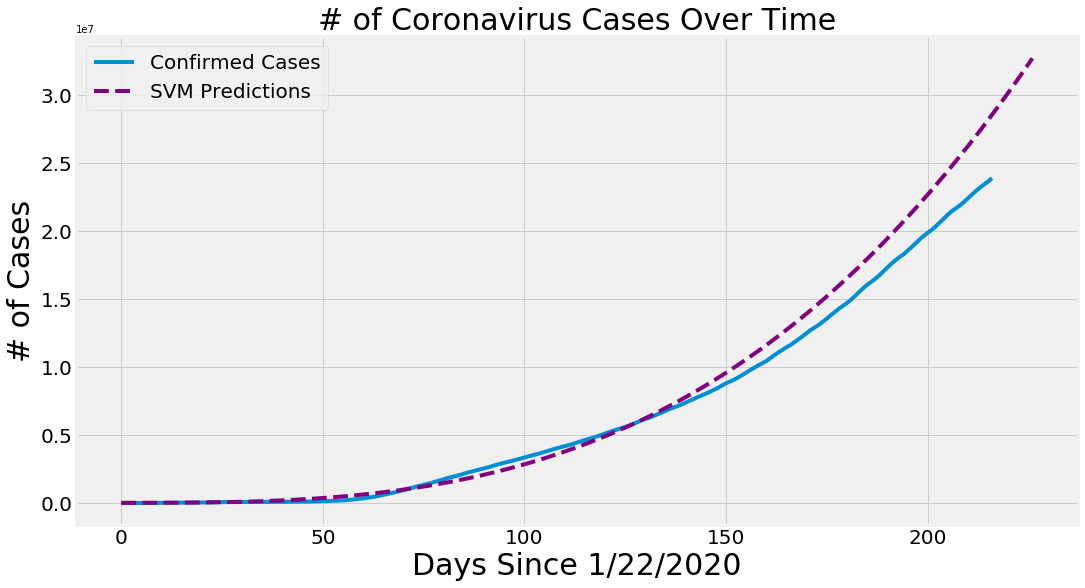

In [84]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')
#plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')
#plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')


In [86]:
# Getting information about countries/regions that have confirmed coronavirus cases
unique_countries =  list(latest_data['Country_Region'].unique())

country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    


In [87]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [88]:
#Visual Representations (bar charts and pie charts)
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 9))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

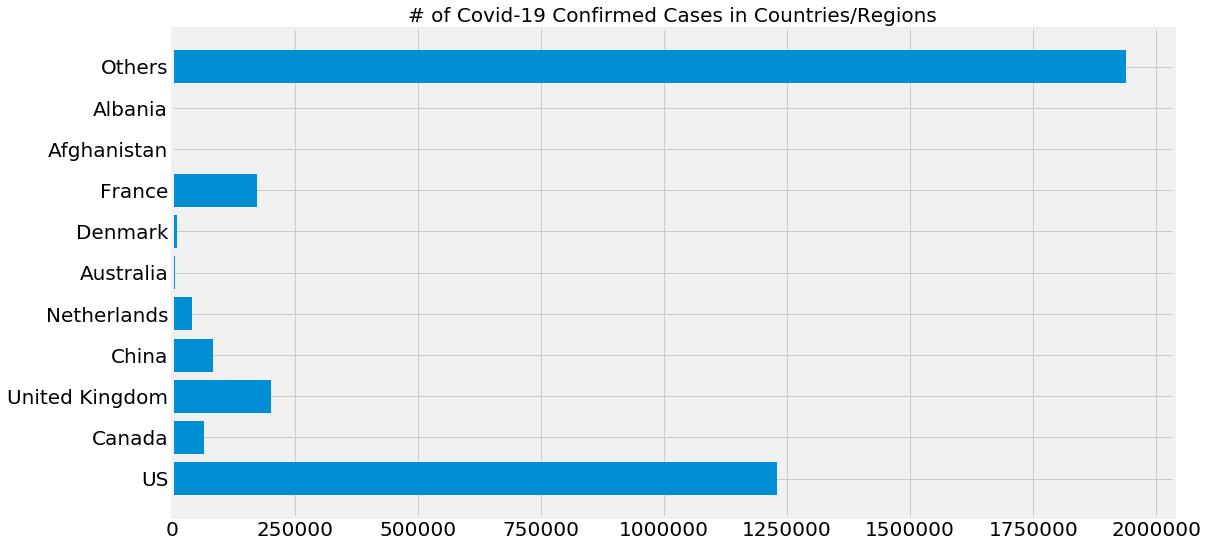

In [89]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

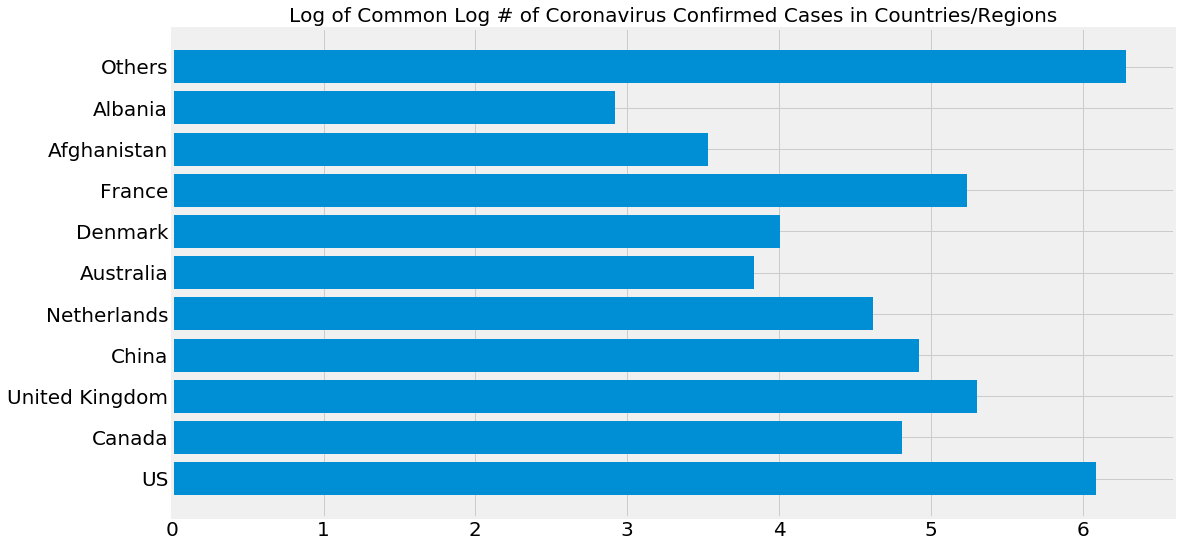

In [90]:
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases, 'Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions')